## Preparação da base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Instalação do detectron2 no colab

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 31.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=9e1c798fe51a8886bd29b1784f4e025421218b6c73197e4b9995991158165535
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 613 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 151 kB 55.5 MB/s 
     |████████████████████████████████| 130 kB 68.4 MB/s 
     |████████████████████████████████| 843 kB 65.6 MB/s 
     |████████████████████████████████| 117 kB 74.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=b3e72e08b87817b09cd8c972d5214ed0623482c95d37c20fe399ea0a1c27f6fb
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144576 sha256=ab42d052c17f8d6e528

In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2


### Dados de configuração do detectron2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 410
        record["width"] = 431
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [54]:
classes = ['dog','cat']

data_path = '/content/drive/MyDrive/datasets/skin detectron 2 data/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

AssertionError: ignored

### Treinando o modelo de segmentação de instância do Detectron2

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/17 23:46:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:52, 8.24MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

[11/17 23:48:00 d2.engine.train_loop]: Starting training from iteration 0
[11/17 23:48:21 d2.utils.events]:  eta: 0:15:56  iter: 19  total_loss: 1.97  loss_cls: 1.169  loss_box_reg: 0.1084  loss_mask: 0.6952  loss_rpn_cls: 0.0003163  loss_rpn_loc: 0.003286  time: 0.9621  data_time: 0.0638  lr: 4.9953e-06  max_mem: 4498M
[11/17 23:48:41 d2.utils.events]:  eta: 0:16:33  iter: 39  total_loss: 1.797  loss_cls: 1.009  loss_box_reg: 0.1056  loss_mask: 0.6844  loss_rpn_cls: 0.0006075  loss_rpn_loc: 0.004299  time: 0.9961  data_time: 0.0066  lr: 9.9902e-06  max_mem: 4498M
[11/17 23:49:02 d2.utils.events]:  eta: 0:16:16  iter: 59  total_loss: 1.462  loss_cls: 0.7008  loss_box_reg: 0.1021  loss_mask: 0.6622  loss_rpn_cls: 0.0005221  loss_rpn_loc: 0.003545  time: 1.0129  data_time: 0.0118  lr: 1.4985e-05  max_mem: 4498M
[11/17 23:49:23 d2.utils.events]:  eta: 0:15:58  iter: 79  total_loss: 1.165  loss_cls: 0.4229  loss_box_reg: 0.101  loss_mask: 0.6275  loss_rpn_cls: 0.0005326  loss_rpn_loc: 0.00

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer, Checkpointer
checkpointer = DetectionCheckpointer(trainer, save_dir=cfg.OUTPUT_DIR)
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/datasets/skin detectron 2 data/data/mymodel.h5")


### Usando o modelo treinado 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [ ]:
# len(test_dataset_dicts) = 7, 7 dictionaries in a list (7 images for test)
# test_dataset_dicts[0] = each dict containing 4 keys: 'file_name', 'height', 'width', 'annotations'

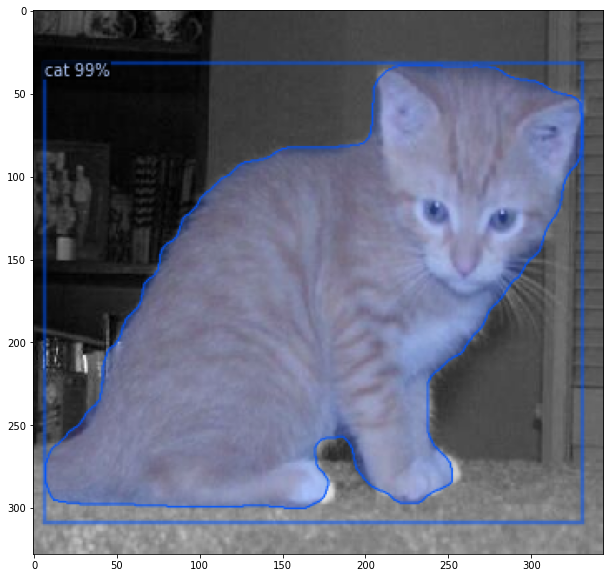

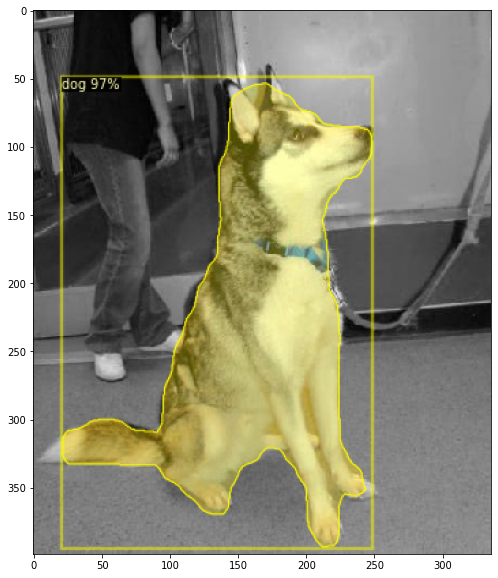

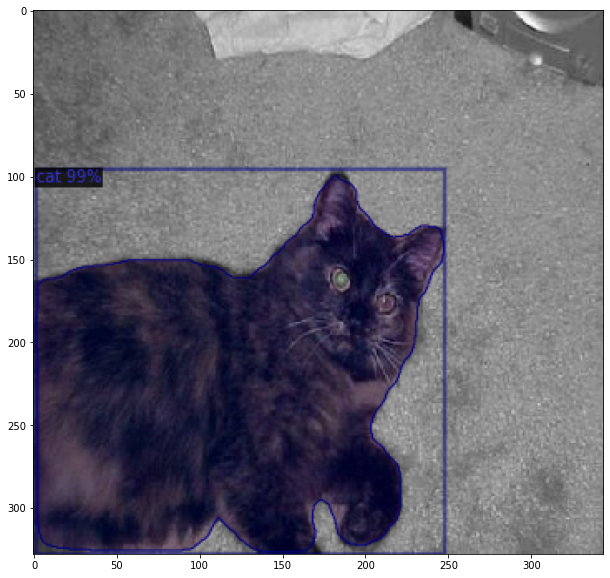

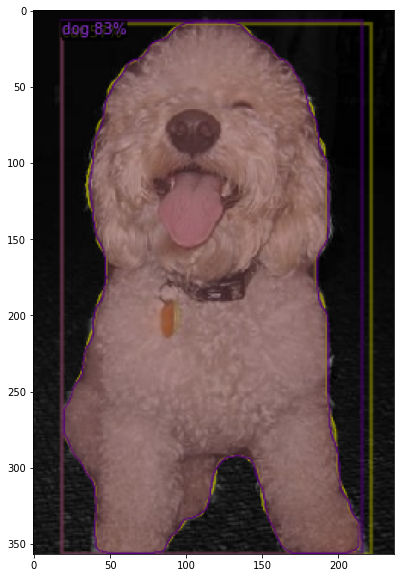

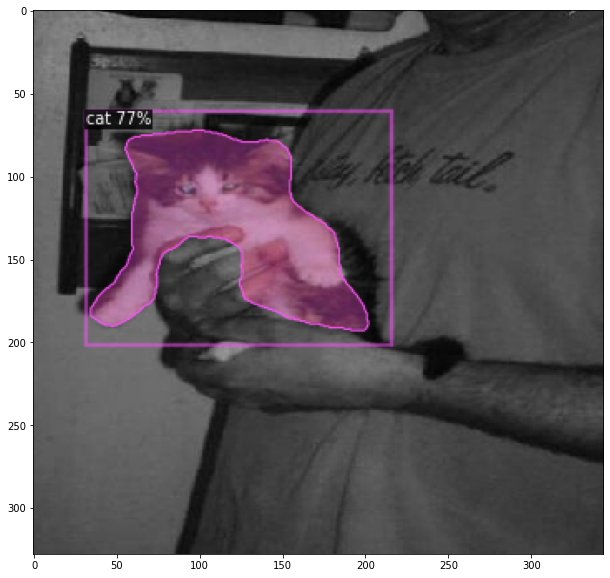

In [51]:
for d in random.sample(test_dataset_dicts, 5):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()